# Modelo de deep learning baseado na memória de curto prazo (LSTM)

## Bibliotecas

In [2]:

# Estamos usando a versão 3.10.11 do python

# pip install pandas tensorflow matplotlib scikit-learn pandas_datareader

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pathlib import Path
import os
pd.options.mode.chained_assignment = None

## Tratmento das bases

In [3]:
# Diretório onde o script está localizado
base_diretório = Path(os.getcwd())
base_diretório = base_diretório.parent
caminho = base_diretório / 'Bases' / 'Bitcoin Historical Data.csv'

# Ler arquivo da base
acao = pd.read_csv(caminho)

# Formatar data
acao['Date'] = pd.to_datetime(acao['Date'], format='%m/%d/%Y')

# Filtrar a data em que vamos puxar os dados
# acao = acao[acao['Date'].dt.year >= 2023]

# Converter as colunas referentes a dinheiro para float
colunas_dinheiro = ['Price', 'Open', 'High', 'Low']
for coluna in colunas_dinheiro:
    if acao[coluna].dtype == 'object':  
        acao[coluna] = pd.to_numeric(acao[coluna].str.replace(',', ''))

# Converter a coluna 'Change %' para float
if acao['Change %'].dtype == 'object':  
    acao['Change %'] = pd.to_numeric(acao['Change %'].str.replace('%', ''))

def converter_vol_para_numero(valor):
    if isinstance(valor, str):  # Verifica se o valor é uma string
        if 'K' in valor:
            return float(valor.replace('K', '').replace(',', '')) * 1000
        elif 'M' in valor:
            return float(valor.replace('M', '').replace(',', '')) * 1000000
        elif 'B' in valor:
            return float(valor.replace('B', '').replace(',', '')) * 1000000000
        else:
            return float(valor.replace(',', ''))
    else:
        return valor  # Retorna o valor diretamente se já for numérico

# Aplicar a função na coluna 'Vol.'
acao['Vol.'] = acao['Vol.'].apply(converter_vol_para_numero)

# Ordenar data das bases
acao = acao.sort_values(by='Date', ascending=True)

acao = acao.rename(columns={'Vol.': 'Volume'})

acao

,Date,Price,Open,High,Low,Volume,Change %
0,2017-01-01,995.4,963.4,1001.6,956.1,41150.0,3.33
1,2017-01-02,1017.0,995.4,1031.7,990.2,64950.0,2.17
2,2017-01-03,1033.3,1017.0,1035.5,1006.5,54790.0,1.60
3,2017-01-04,1135.4,1033.3,1148.5,1022.3,156270.0,9.88
4,2017-01-05,989.3,1135.4,1150.6,874.5,240010.0,-12.86
...,...,...,...,...,...,...,...
2795,2024-08-27,59450.9,62832.2,63201.4,58187.3,108530.0,-5.40
2796,2024-08-28,59016.0,59425.6,60198.4,57912.1,109470.0,-0.73
2797,2024-08-29,59373.5,59027.3,61150.6,58807.1,87190.0,0.61
2798,2024-08-30,59119.7,59371.7,59817.6,57874.7,87310.0,-0.43


## Aplicando modelo de ML

In [4]:
#nao pode ser ajustados

cotacao = acao['Price'].to_numpy().reshape(-1, 1)

cotacao

array([[  995.4],
       [ 1017. ],
       [ 1033.3],
       ...,
       [59373.5],
       [59119.7],
       [58978.6]])

In [5]:
tamanho_dados_treinamento = int(len(cotacao) * 0.8)

tamanho_dados_treinamento

2240

In [6]:
#escalar os dados entre 0 e 1, para deixar mais fácil o processamento
#dados em escala pré definidas são mais fáceis de lidar. 

escalador = MinMaxScaler(feature_range=(0, 1))

dados_entre_0_e_1_treinamento = escalador.fit_transform(cotacao[0: tamanho_dados_treinamento, :])

dados_entre_0_e_1_teste = escalador.transform(cotacao[tamanho_dados_treinamento: , :])

dados_entre_0_e_1 = list(dados_entre_0_e_1_treinamento.reshape(
    len(dados_entre_0_e_1_treinamento))) + list(dados_entre_0_e_1_teste.reshape(len(dados_entre_0_e_1_teste)))
                                                

dados_entre_0_e_1 = np.array(dados_entre_0_e_1).reshape(len(dados_entre_0_e_1), 1)

dados_entre_0_e_1

array([[0.00314642],
       [0.00347005],
       [0.00371428],
       ...,
       [0.87782298],
       [0.8740203 ],
       [0.87190621]])

In [7]:
dados_para_treinamento = dados_entre_0_e_1[0: tamanho_dados_treinamento, :]

#dados que serão usados para gerar o resultado
treinamento_x = []
#cotação que aconteceu de fato
treinamento_y = []


for i in range(60, len(dados_para_treinamento)):

    #60 ultimos dias
    treinamento_x.append(dados_para_treinamento[i - 60: i, 0])
    #cotacao
    treinamento_y.append(dados_para_treinamento[i, 0])

    if i <= 61:

        print(treinamento_x)
        print(treinamento_y)



[array([0.00314642, 0.00347005, 0.00371428, 0.00524403, 0.00305502,
       0.00151028, 0.00155074, 0.00173053, 0.00171405, 0.00178297,
       0.        , 0.00037008, 0.00059033, 0.00051242, 0.00053639,
       0.00062779, 0.00171255, 0.00129752, 0.00164513, 0.00161067,
       0.00201371, 0.00199873, 0.00203918, 0.00162415, 0.00163314,
       0.00195078, 0.00198674, 0.00199423, 0.0019343 , 0.00202719,
       0.00269843, 0.00295164, 0.00327527, 0.00341012, 0.0036918 ,
       0.00345657, 0.00358542, 0.0039585 , 0.0040469 , 0.0029007 ,
       0.00317938, 0.0033397 , 0.0031629 , 0.00314642, 0.0033397 ,
       0.0033382 , 0.0036933 , 0.0039555 , 0.00399895, 0.00394801,
       0.00437802, 0.00499831, 0.00502079, 0.00579091, 0.00585983,
       0.0054493 , 0.00578642, 0.00604412, 0.00605162, 0.00655205])]
[0.007043488032363187]
[array([0.00314642, 0.00347005, 0.00371428, 0.00524403, 0.00305502,
       0.00151028, 0.00155074, 0.00173053, 0.00171405, 0.00178297,
       0.        , 0.00037008, 0.00

In [8]:
#transformando as listas em arrays e dando reshape 3d 

treinamento_x, treinamento_y = np.array(treinamento_x), np.array(treinamento_y)

print(treinamento_x)

treinamento_x = treinamento_x.reshape(treinamento_x.shape[0], treinamento_x.shape[1], 1)

print(treinamento_x)

[[0.00314642 0.00347005 0.00371428 ... 0.00604412 0.00605162 0.00655205]
 [0.00347005 0.00371428 0.00524403 ... 0.00605162 0.00655205 0.00704349]
 [0.00371428 0.00524403 0.00305502 ... 0.00655205 0.00704349 0.00746001]
 ...
 [0.23906357 0.23457167 0.24148631 ... 0.31445031 0.32083155 0.35273626]
 [0.23457167 0.24148631 0.24042252 ... 0.32083155 0.35273626 0.3409252 ]
 [0.24148631 0.24042252 0.24025471 ... 0.35273626 0.3409252  0.35641608]]
[[[0.00314642]
  [0.00347005]
  [0.00371428]
  ...
  [0.00604412]
  [0.00605162]
  [0.00655205]]

 [[0.00347005]
  [0.00371428]
  [0.00524403]
  ...
  [0.00605162]
  [0.00655205]
  [0.00704349]]

 [[0.00371428]
  [0.00524403]
  [0.00305502]
  ...
  [0.00655205]
  [0.00704349]
  [0.00746001]]

 ...

 [[0.23906357]
  [0.23457167]
  [0.24148631]
  ...
  [0.31445031]
  [0.32083155]
  [0.35273626]]

 [[0.23457167]
  [0.24148631]
  [0.24042252]
  ...
  [0.32083155]
  [0.35273626]
  [0.3409252 ]]

 [[0.24148631]
  [0.24042252]
  [0.24025471]
  ...
  [0.3527

In [9]:
#construindo o modelo

modelo = Sequential()

#vamos criar um modelo com 50 neurônios
#return sequences = True pois vamos usar outro LSTM depois.
#definir o shape, que no caso são 60 informações para gerar uma.
#Adicionar mais neurônios com o dense, 25 e 1
#Não se apegue a isso agora, é apenas um arquitetura de deep learning.

# Primeira camada LSTM com dropout
modelo.add(LSTM(100, return_sequences=True, input_shape=(treinamento_x.shape[1], 1)))
# modelo.add(Dropout(0.2))

# Segunda camada LSTM
modelo.add(LSTM(50, return_sequences=False))
# modelo.add(Dropout(0.2))

# Camada totalmente conectada com 25 neurônios
modelo.add(Dense(25))

# Camada final de saída com 1 neurônio
modelo.add(Dense(1))

treinamento_x.shape[1]

c:\Users\Arq. Andrea\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60

In [10]:
#copilando o modelo

# a função de loss é a forma de medir o erro do modelo, que nesse caso
#é o classico erro médio quadrático da que é usado em regressão linear
#otimizador e medida de erro

modelo.compile(optimizer="adam", loss="mean_squared_error") 

In [11]:
#agora com o modelo copilado e os dados, podemos treinar o modelo
#batch size é depois de quantas em quantas amostras o modelo irá otimizar os parâmetros.
#epochs é quantas vezes o algoritmo irá rodar os dados treinamento, aprendendo. 

modelo.fit(treinamento_x, treinamento_y, batch_size=20, epochs=10)

Epoch 1/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0116
Epoch 2/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0012
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 7.5207e-04
Epoch 4/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 6.7139e-04
Epoch 5/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 8.3438e-04
Epoch 6/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 4.9552e-04
Epoch 7/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 4.9481e-04
Epoch 8/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 4.6202e-04
Epoch 9/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 4.5695e-04
Epoch 10/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 4.7108e-04


In [12]:
# Vriar dados de teste

dados_teste = dados_entre_0_e_1[tamanho_dados_treinamento - 60:, :]

teste_x = []
teste_y = cotacao[tamanho_dados_treinamento: , :] 

for i in range(60, len(dados_teste)):
    teste_x.append(dados_teste[i - 60: i, 0])
    

In [13]:
# Reshape
teste_x = np.array(teste_x)
teste_x = teste_x.reshape(teste_x.shape[0], teste_x.shape[1], 1)

In [14]:
#pegando predições do modelo

predicoes = modelo.predict(teste_x)

#tirando a escala dos dados

predicoes = escalador.inverse_transform(predicoes)

predicoes

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


array([[24274.73 ],
       [24490.52 ],
       [24660.59 ],
       [24631.408],
       [24441.293],
       [24157.436],
       [23696.559],
       [23288.62 ],
       [23128.516],
       [23100.441],
       [23044.045],
       [23150.305],
       [23250.275],
       [23015.045],
       [22715.79 ],
       [22493.482],
       [22357.092],
       [22235.818],
       [22022.395],
       [21461.566],
       [20863.523],
       [20494.389],
       [20731.771],
       [21743.5  ],
       [22985.346],
       [23881.607],
       [24594.38 ],
       [25707.566],
       [26501.967],
       [27232.26 ],
       [27622.38 ],
       [27855.227],
       [27672.043],
       [27679.145],
       [27484.85 ],
       [27276.463],
       [27276.68 ],
       [27113.662],
       [26993.203],
       [27262.592],
       [27522.23 ],
       [27855.627],
       [28124.566],
       [28217.396],
       [28094.727],
       [28030.127],
       [28002.906],
       [27955.879],
       [27878.1  ],
       [27821.975],


In [15]:
# Criando o grafico do modelo
treinamento = acao.iloc[:tamanho_dados_treinamento, :]
df_previsao = pd.DataFrame({"Date": acao['Date'].iloc[tamanho_dados_treinamento:],
                        "Price": acao['Price'].iloc[tamanho_dados_treinamento:],
                        "predicoes": predicoes.reshape(len(predicoes))})


In [16]:
treinamento

,Date,Price,Open,High,Low,Volume,Change %
0,2017-01-01,995.4,963.4,1001.6,956.1,41150.0,3.33
1,2017-01-02,1017.0,995.4,1031.7,990.2,64950.0,2.17
2,2017-01-03,1033.3,1017.0,1035.5,1006.5,54790.0,1.60
3,2017-01-04,1135.4,1033.3,1148.5,1022.3,156270.0,9.88
4,2017-01-05,989.3,1135.4,1150.6,874.5,240010.0,-12.86
...,...,...,...,...,...,...,...
2235,2023-02-14,22198.5,21776.9,22308.6,21556.2,378390.0,1.96
2236,2023-02-15,24327.9,22198.5,24330.9,22050.8,401530.0,9.59
2237,2023-02-16,23539.6,24328.1,25233.8,23525.9,484500.0,-3.24
2238,2023-02-17,24573.5,23538.2,24984.7,23373.0,523850.0,4.39


In [17]:
df_previsao

,Date,Price,predicoes
2240,2023-02-19,24302.9,24274.730469
2241,2023-02-20,24839.5,24490.519531
2242,2023-02-21,24450.7,24660.589844
2243,2023-02-22,24186.6,24631.408203
2244,2023-02-23,23936.3,24441.292969
...,...,...,...
2795,2024-08-27,59450.9,63413.960938
2796,2024-08-28,59016.0,61437.968750
2797,2024-08-29,59373.5,59413.351562
2798,2024-08-30,59119.7,58238.472656


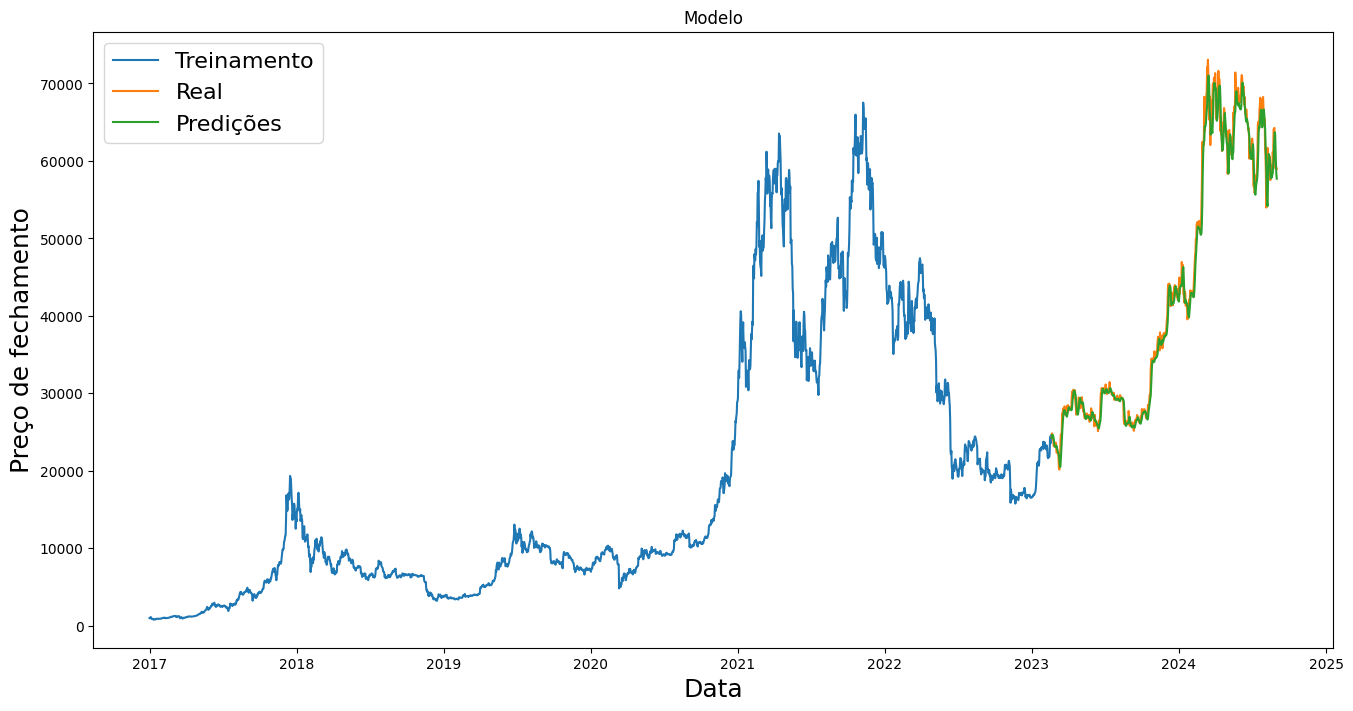

In [18]:
# Setar a data como index dos df (df_previsao e treinamento)
df_previsao.set_index('Date', inplace=True)
treinamento.set_index('Date', inplace=True)

plt.figure(figsize =(16, 8))
plt.title('Modelo')
plt.xlabel('Data', fontsize = 18)
plt.ylabel("Preço de fechamento", fontsize = 18)
plt.plot(treinamento[['Price']])
plt.plot(df_previsao[['Price', 'predicoes']])
plt.legend(['Treinamento', 'Real', 'Predições'], loc=2, prop={'size': 16})
plt.show()

In [19]:
df_previsao.sort_index()

df_previsao

,Price,predicoes
Date,,
2023-02-19,24302.9,24274.730469
2023-02-20,24839.5,24490.519531
2023-02-21,24450.7,24660.589844
2023-02-22,24186.6,24631.408203
2023-02-23,23936.3,24441.292969
...,...,...
2024-08-27,59450.9,63413.960938
2024-08-28,59016.0,61437.968750
2024-08-29,59373.5,59413.351562


In [20]:
df_previsao_semanal = df_previsao
df_previsao_semanal['Semana'] = ((df_previsao_semanal.index - df_previsao_semanal.index.min()).days // 7) + 1
df_previsao_semanal.head(30)

,Price,predicoes,Semana
Date,,,
2023-02-19,24302.9,24274.730469,1
2023-02-20,24839.5,24490.519531,1
2023-02-21,24450.7,24660.589844,1
2023-02-22,24186.6,24631.408203,1
2023-02-23,23936.3,24441.292969,1
2023-02-24,23191.5,24157.435547,1
2023-02-25,23166.1,23696.558594,1
2023-02-26,23558.7,23288.619141,2
2023-02-27,23494.1,23128.515625,2


# Metricas para calcular nosso modelo de ML

### Mean Absolute Error (MAE) e Mean Absolute Percentage Error (MAPE)

In [21]:
# A média das diferenças absolutas entre as previsões e os valores reais. Penaliza todos os erros da mesma forma

mae = mean_absolute_error(df_previsao['Price'], df_previsao['predicoes'])

print(f"Mean Absolute Error (MAE): {mae:.2f}")

Mean Absolute Error (MAE): 1044.86


In [22]:
# Calcular o MAPE
mape = mean_absolute_percentage_error(df_previsao['Price'], df_previsao['predicoes'])

print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f} = {100*mape:.2f}%")

Mean Absolute Percentage Error (MAPE): 0.0230 = 2.30%


### Root Mean Squared Error (RMSE)

In [23]:
# A raiz quadrada da média dos erros ao quadrado. Dá mais peso a grandes erros

rmse = mean_squared_error(df_previsao['Price'], df_previsao['predicoes'], squared=False)
mean_price = df_previsao['Price'].mean()

print(f"RMSE: {rmse}")
print(f"RMSE percentual: {(rmse / mean_price)*100:.3}%")

RMSE: 1566.2639861087587
RMSE percentual: 3.63%


c:\Users\Arq. Andrea\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### R² (Coeficiente de Determinação)

In [24]:
# o R² mede a proporção da variância nos dados que é explicada pelo modelo. Um valor de 1 significa previsões 
# perfeitas, enquanto valores negativos indicam que o modelo é pior do que uma simples média.

r2 = r2_score(df_previsao['Price'], df_previsao['predicoes'])

print(f"R²: {r2}")
print(f"R²: {r2*100:.4}%")

R²: 0.9910337555445716
R²: 99.1%


### Directional Accuracy (Semanal)

In [25]:
# Agrupar por semana e calcular o preço médio semanal para real e previsões
df_teste_semana = df_previsao_semanal.groupby('Semana').agg({
    'Price': 'mean',        # Preço real médio por semana
    'predicoes': 'mean'     # Previsão média por semana
})

# Calcular a variação percentual semanal para Price e Predicoes
df_teste_semana['Variação Real (%)'] = df_teste_semana['Price'].pct_change() * 100
df_teste_semana['Variação Prevista (%)'] = df_teste_semana['predicoes'].pct_change() * 100


# Remover NaN (primeira linha não terá variação por não ter valor anterior)
df_teste_semana = df_teste_semana.dropna()

# Calcular se a direção do valor previsto foi igual ao real (1 = acertou | 0 = errou)
df_teste_semana['direcao_correta'] = np.where(
    (df_teste_semana['Variação Real (%)'] > 0) & (df_teste_semana['Variação Prevista (%)'] > 0) |
    (df_teste_semana['Variação Real (%)'] < 0) & (df_teste_semana['Variação Prevista (%)'] < 0),
    1, 0
)

# Calcular a métrica de Erro de Direção (Directional Accuracy)
directional_accuracy = df_teste_semana['direcao_correta'].mean()

# Exibir resultados
print(f"Directional Accuracy (Semanal): {directional_accuracy * 100:.2f}%")

df_teste_semana

Directional Accuracy (Semanal): 87.34%


,Price,predicoes,Variação Real (%),Variação Prevista (%),direcao_correta
Semana,,,,,
2,23141.771429,23139.607422,-3.618177,-4.916441,1
3,21390.414286,22021.380859,-7.567948,-4.832524,1
4,24914.571429,22876.937500,16.475404,3.885114,1
5,27757.628571,27435.410156,11.411222,19.926060,1
6,27953.600000,27328.636719,0.706009,-0.389183,0
...,...,...,...,...,...
76,64773.457143,65238.191406,-3.234810,-0.432253,1
77,58111.642857,57177.558594,-10.284790,-12.355698,1
78,59037.314286,59642.269531,1.592919,4.310632,1


In [27]:
df_teste_semana.to_csv("previsão semanal.csv")

In [36]:
#criando um código que você passa 60 dias e ele devolve a cotação
#resumindo: vamos descobrir o preço da petrobras de hoje/amanha com esse modelo

# data_hoje = datetime.now()

#se quiser escolher um dia, basta fazer assim

#data_hoje = datetime.now() - timedelta(days = 1)

# if data_hoje.hour > 18:
    
#     final = data_hoje
#     inicial = datetime.now() - timedelta(days = 252)
    
# else:
#     final = data_hoje - timedelta(days = 1)
#     inicial = datetime.now() - timedelta(days = 252)
    
# ultimos_60_dias = acao['Price'].iloc[-60:].values.reshape(-1, 1)

# ultimos_60_dias_escalado = escalador.transform(ultimos_60_dias)

# teste_x = []
# teste_x.append(ultimos_60_dias_escalado)
# teste_x = np.array(teste_x)
# teste_x = teste_x.reshape(teste_x.shape[0], teste_x.shape[1], 1)

# previsao_de_preco = modelo.predict(teste_x)
# previsao_de_preco = escalador.inverse_transform(previsao_de_preco)

# print(previsao_de_preco)